In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from plotly.offline import init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots
import plotly.express as px
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

<h2>Loading Data</h2>

In [2]:
drug_related_deaths = pd.read_csv("inputs/CT_Accidental_Drug_Related_Deaths_2012-2020_raw.csv");
drug_related_deaths.head()

,ID,Date,Date Type,Age,Sex,Race,Residence City,Residence County,Residence State,Death City,...,Morphine (Not Heroin),Hydromorphone,Xylazine,Other,Opiate NOS,Any Opioid,Manner of Death,DeathCityGeo,ResidenceCityGeo,InjuryCityGeo
0,12-0187,07/17/2012,DateofDeath,34.0,Female,White,MAHOPAC,PUTNAM,NaN,DANBURY,...,NaN,NaN,NaN,Duster,NaN,NaN,Accident,"DANBURY, CT\n(41.393666, -73.451539)",NaN,"CT\n(41.575155, -72.738288)"
1,12-0258,10/01/2012,DateofDeath,51.0,Male,White,PORTLAND,MIDDLESEX,NaN,PORTLAND,...,NaN,NaN,NaN,NaN,NaN,NaN,Accident,"PORTLAND, CT\n(41.581345, -72.634112)","PORTLAND, CT\n(41.581345, -72.634112)","CT\n(41.575155, -72.738288)"
2,13-0146,04/28/2013,DateofDeath,28.0,Male,White,NaN,NaN,NaN,HARTFORD,...,NaN,NaN,NaN,NaN,NaN,NaN,Accident,"HARTFORD, CT\n(41.765775, -72.673356)","CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)"
3,14-0150,04/06/2014,DateofDeath,46.0,Male,White,WATERBURY,NaN,NaN,TORRINGTON,...,NaN,NaN,NaN,NaN,NaN,NaN,Accident,"TORRINGTON, CT\n(41.812186, -73.101552)","WATERBURY, CT\n(41.554261, -73.043069)","CT\n(41.575155, -72.738288)"
4,14-0183,04/27/2014,DateofDeath,52.0,Male,White,NEW LONDON,NaN,NaN,NEW LONDON,...,NaN,NaN,NaN,NaN,NaN,NaN,Accident,"NEW LONDON, CT\n(41.355167, -72.099561)","NEW LONDON, CT\n(41.355167, -72.099561)","CT\n(41.575155, -72.738288)"


In [3]:
opioids = pd.read_csv("inputs/opioids.csv")
opioids.head()

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


In [4]:
overdoses = pd.read_csv("inputs/overdoses.csv")
overdoses.head()

,State,Population,Deaths,Abbrev
0,Alabama,"4,833,722",723,AL
1,Alaska,"735,132",124,AK
2,Arizona,"6,626,624","1,211",AZ
3,Arkansas,"2,959,373",356,AR
4,California,"38,332,521","4,521",CA


In [5]:
prescriber = pd.read_csv("inputs/prescriber-info.csv")
prescriber.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


<h2>Data Preprocessing</h2>

In [6]:
overdoses['Deaths'] = overdoses['Deaths'].str.replace(',', '')
overdoses['Deaths'] = overdoses['Deaths'].astype(int)

In [7]:
overdoses['Population'] = overdoses['Population'].str.replace(',', '')
overdoses['Population'] = overdoses['Population'].astype(int)

In [8]:
overdoses['Deaths Per Capita'] = (overdoses['Deaths']/overdoses['Population'])

In [9]:
overdoses.head()

,State,Population,Deaths,Abbrev,Deaths Per Capita
0,Alabama,4833722,723,AL,0.000150
1,Alaska,735132,124,AK,0.000169
2,Arizona,6626624,1211,AZ,0.000183
3,Arkansas,2959373,356,AR,0.000120
4,California,38332521,4521,CA,0.000118


In [10]:
def plot_graph(deaths_per_capita, states, title):
    
    ## Bar chart
    Xaxis = deaths_per_capita
    Yaxis = states #similar_df.loc[player_id].map(id_name).values[::-1]

    fig = go.Figure(go.Bar(
                x=Xaxis,
                y=Yaxis,
                orientation='h'))
    
    fig.update_layout(title_text=title)
    fig.show()

In [11]:
states = overdoses['State'] 
death_per_capita = overdoses['Deaths Per Capita']
title = "Deaths per capita"
plot_graph(death_per_capita, states, title)


states = overdoses['State'] 
death_per_capita = overdoses['Deaths']
title = "Deaths"
plot_graph(death_per_capita, states, title)    

# plt.rcdefaults()
# fig, ax = plt.subplots()

# death_per_capita = overdoses['Deaths Per Capita']
# states = overdoses['State'] 
# y_pos = np.arange(len(overdoses['State']))
# error = np.random.rand(len(overdoses['State']))

# ax.barh(y_pos, death_per_capita, align='center')
# ax.set_yticks(y_pos)
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('States')
# ax.set_title('Deaths Per Capita')


# plt.show()

<h2>Data Cleaning</h2>

<h>Comparing the number of states between our datasets</h>

In [12]:
prescriber.State.unique()

array(['TX', 'AL', 'NY', 'AZ', 'NV', 'PA', 'NH', 'WI', 'PR', 'CO', 'OH',
       'MA', 'CT', 'FL', 'MN', 'UT', 'IA', 'IL', 'MT', 'IN', 'VA', 'CA',
       'OR', 'NE', 'MI', 'NM', 'TN', 'KS', 'LA', 'MD', 'MO', 'AR', 'NC',
       'NJ', 'SC', 'WY', 'ME', 'OK', 'ND', 'KY', 'GA', 'DE', 'WA', 'RI',
       'WV', 'AK', 'ID', 'VT', 'HI', 'MS', 'DC', 'SD', 'AE', 'ZZ', 'GU',
       'AA', 'VI'], dtype=object)

In [13]:
# Compare to overdoses dataset
overdoses.Abbrev.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

<h>We can see that the number of states between the two datasets aren't equal.</h>
<h>So, We'll compare the state list & clean up states to make the dataset state list equal.<h>
<h>Removing the extra states from the prescriber datasets, we get the following</h>

In [14]:
prescriber = prescriber[prescriber.State != 'AE']
prescriber = prescriber[prescriber.State != 'ZZ']
prescriber = prescriber[prescriber.State != 'AA']
prescriber = prescriber[prescriber.State != 'PR']
prescriber = prescriber[prescriber.State != 'GU']
prescriber = prescriber[prescriber.State != 'VI']

In [15]:
prescriber.State.unique()

array(['TX', 'AL', 'NY', 'AZ', 'NV', 'PA', 'NH', 'WI', 'CO', 'OH', 'MA',
       'CT', 'FL', 'MN', 'UT', 'IA', 'IL', 'MT', 'IN', 'VA', 'CA', 'OR',
       'NE', 'MI', 'NM', 'TN', 'KS', 'LA', 'MD', 'MO', 'AR', 'NC', 'NJ',
       'SC', 'WY', 'ME', 'OK', 'ND', 'KY', 'GA', 'DE', 'WA', 'RI', 'WV',
       'AK', 'ID', 'VT', 'HI', 'MS', 'DC', 'SD'], dtype=object)

<h>Listing out all Credentials</h>

In [16]:
prescriber.Credentials.unique()

array(['DDS', 'MD', 'M.D.', 'DO', 'RN, MSN, ANP-BC', 'O.D.', nan,
       'D.D.S.', 'ACNP', 'DPM', 'PAC', 'A.R.N.P.', 'MSN, APRN, BC',
       'D.O.', 'M.D,', 'APRN', 'PA-C', 'CNM', 'RN CNP', 'DDS MS',
       'DNP, APRN-BC, FNP', 'PHARM D.', 'CRNP', 'ARNP', 'D.D.S', 'DPM MD',
       'FNP', 'NP', 'DMD', 'PA', 'MPT', 'D.M.D.', 'APRN BC FNP',
       'DMD,FAGD', 'MD,MPH', 'BDS,  DDS', 'D.D.S., F.A.G.D.', 'DDS, MD',
       'PMH, CNP/CNS', 'P.A.', 'M.D', 'D.O., MPH & TM', 'M.D., PH.D.',
       'RPA-C', 'MD FACOG', 'F.N.P.', 'D.O', 'ANP', 'FNP-C', 'D.M.D',
       'D.P.M.', 'OD', 'O. D.', 'CNS', 'MS, APRN, FNP-C', 'MD MPH',
       'NP-C', 'PHARM D', 'M.D.,', 'MBBS', 'PHYSICIAN ASSISTANT',
       'M.D. FCCP', 'MD.', 'CNP', 'DPT', 'D.D.S, M.D.', 'APRN, BC',
       'P.A.-C', 'M.D.P.A.', 'F.N.P.-C', 'M. D.', 'CFNP', 'C.N.P', 'APN',
       'D.D.S., A.P.C.', 'NP-C, MSN', 'MD FACP', 'R.P.A.', 'N.P.',
       'APRN, CNS', 'D.D.S., M.D.', 'PMHNP', 'MD, PHD, ABFP', 'APNP',
       'DMD, MD, PLLC', 'M.D., P.

<h>Listing out specialities</h>

In [17]:
prescriber.Specialty.unique()

array(['Dentist', 'General Surgery', 'General Practice',
       'Internal Medicine', 'Hematology/Oncology', 'Family Practice',
       'Nurse Practitioner', 'Optometry', 'Cardiology',
       'Obstetrics/Gynecology', 'Podiatry', 'Physician Assistant',
       'Diagnostic Radiology',
       'Student in an Organized Health Care Education/Training Program',
       'Neurology', 'Certified Nurse Midwife', 'Rheumatology',
       'Pharmacist', 'Urology', 'Cardiac Electrophysiology',
       'Dermatology', 'Emergency Medicine', 'Psychiatry & Neurology',
       'Infectious Disease', 'Psychiatry', 'Gastroenterology',
       'Ophthalmology', 'Thoracic Surgery',
       'Oral Surgery (dentists only)', 'Anesthesiology',
       'Orthopedic Surgery', 'Otolaryngology', 'Pulmonary Disease',
       'Neuropsychiatry', 'Physical Therapist', 'Pediatric Medicine',
       'Physical Medicine and Rehabilitation', 'Maxillofacial Surgery',
       'Certified Clinical Nurse Specialist', 'Preventive Medicine',
       'A

<h>Male <b>vs</b> Female</h>

In [18]:
prescriber.groupby('Gender').size() / prescriber.groupby('Gender').size().sum()

Gender
F    0.378166
M    0.621834
dtype: float64

<h>The number of prescribers who prescribed opioid drugs <b>vs</b> those who did not</h>

In [19]:
prescriber.groupby('Opioid.Prescriber').size() / prescriber.groupby('Opioid.Prescriber').size().sum()

Opioid.Prescriber
0    0.41282
1    0.58718
dtype: float64

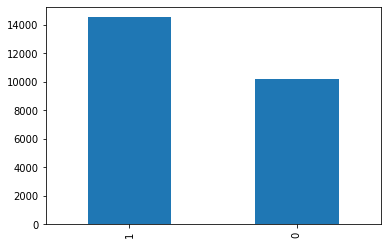

In [20]:
# Plotting
pd.value_counts(prescriber['Opioid.Prescriber']).plot.bar()
plt.show()

<h>We can see from the above graph that our dataset has a slightly higher number of opioid prescribers</h>